# Load LLM, SAEs

sae layers: [7, 14, 21, 40]
llm gemma 9b

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
import circuitsvis as cv
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, FactoredMatrix
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import functools
import pandas as pd
from pprint import pprint as pp
from typing import Tuple
from torch import Tensor
from functools import lru_cache
from torch import tensor
from typing import TypedDict, Optional, Tuple, Union
from tqdm import tqdm
import signal

from sae_lens import SAE, HookedSAETransformer
import transformer_lens
import json
import random
import wandb
import os

# Load a model
model = transformer_lens.HookedTransformer.from_pretrained("gemma-2-9b", device="cuda")
pad_token_id = model.tokenizer.pad_token_id
print('pad token id is', pad_token_id)

for param in model.parameters():
   param.requires_grad_(False)

device = "cuda"



/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-9b into HookedTransformer
pad token id is 0


In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"


In [3]:
layers= [7, 14, 21, 40]
l0s = [92, 67, 129, 125]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res", sae_id=f"layer_{layers[i]}/width_16k/average_l0_{l0s[i]}", device=device)[0] for i in range(len(layers))]

# Load Dataset

In [4]:
@lru_cache(maxsize=None)
def memoize_encode(text):
    return(model.to_tokens(text))

In [5]:
# Expanding the name pool with a larger set of names
extended_name_pool = [
    "Bob", "Sam", "Lilly", "Rob", "Alice", "Charlie", "Sally", "Tom", "Jake", "Emily", 
    "Megan", "Chris", "Sophia", "James", "Oliver", "Isabella", "Mia", "Jackson", 
    "Emma", "Ava", "Lucas", "Benjamin", "Ethan", "Grace", "Olivia", "Liam", "Noah", "Diego"
]
for name in extended_name_pool:
    assert len(model.tokenizer.encode(name)) == 2, f"Name {name} has more than 1 token"
# Function to generate the dataset with correct and incorrect keying into dictionaries
def generate_extended_dataset(name_pool, num_samples=5):
    dataset = []
    for _ in range(num_samples):
        # Randomly select 5 names from the pool
        selected_names = random.sample(name_pool, 5)
        # Assign random ages to the selected names
        age_dict = {name: random.randint(10, 19) for name in selected_names}
        # Create a correct example
        correct_name = random.choice(list(age_dict.keys()))
        correct_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{correct_name}"]\n'
        correct_response = age_dict[correct_name]
        correct_token = str(correct_response)[0]
        # Create an incorrect example with a name not in the dictionary
        
        incorrect_name = random.choice([name for name in name_pool if name not in age_dict])
        if random.random()>0.5:
            # put the new name in the key.
            incorrect_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{incorrect_name}"]\n'
        else:
            # put the new name in the dict, and swap the key.
            keys = list(age_dict.keys())
            items = list(age_dict.values())

            location = keys.index(correct_name)
            keys[location] = incorrect_name

            
            broken_age_dict = dict(zip(keys, items))
            incorrect_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {broken_age_dict}\n>>> age["{correct_name}"]\n'
            
            
            


        incorrect_response = "Traceback"
        incorrect_token = "Traceback"

        # Append the pair of correct and incorrect examples
        dataset.append({
            "correct": {
                "prompt": correct_prompt,
                "response": correct_response,
                "token": correct_token
            },
            "error": {
                "prompt": incorrect_prompt,
                "response": incorrect_response,
                "token": incorrect_token
            }
        })
    return dataset
# Generate the extended dataset
json_dataset = generate_extended_dataset(extended_name_pool, num_samples=100_000)

In [6]:
simple_dataset_ex_len = 65

In [7]:
def response_to_token(response):
    return memoize_encode(str(response)).squeeze()[1]

class ContrastiveDatasetBatch:
    def __init__(self, dataset_items):
        self.correct_batch = [item["correct"] for item in dataset_items]
        self.error_batch = [item["error"] for item in dataset_items]
        self.batch_size = len(self.correct_batch)
        self.correct_token_idx = model.to_single_token("1")
        self.error_token_idx = model.to_single_token("Traceback")

        correct_tokenized = None
        error_tokenized = None

        correct_prompts = [example["prompt"] for example in self.correct_batch]
        error_prompts = [example["prompt"] for example in self.error_batch]

        correct_answers = torch.tensor([response_to_token(example['response']) for example in self.correct_batch], dtype=torch.int64)
        error_answers = torch.tensor([response_to_token(example['response']) for example in self.error_batch], dtype=torch.int64)

        assert len(correct_prompts) == len(error_prompts)
        all_prompts = correct_prompts + error_prompts
        all_tokenized = model.to_tokens(all_prompts)
        last_non_pad_idxs = torch.count_nonzero(all_tokenized != pad_token_id, dim=-1) - 1


        correct_tokenized = all_tokenized[:self.batch_size]
        correct_answer_idxs = last_non_pad_idxs[:self.batch_size]
        error_tokenized = all_tokenized[self.batch_size:]
        error_answer_idxs = last_non_pad_idxs[self.batch_size:]

        self.correct_tokenized = correct_tokenized
        self.error_tokenized = error_tokenized
        self.correct_answer_seq_idxs = correct_answer_idxs
        self.error_answer_seq_idxs = error_answer_idxs
        self.correct_labels = correct_answers
        self.error_labels = error_answers

        self.all_tokenized = all_tokenized
        self.all_answer_seq_idxs = last_non_pad_idxs
        self.all_prompts = all_prompts
        # the tokens are: [correct prompt, correct prompt, ..., error prompt, error prompt, ...]
        self.all_answers_tok_idxs = torch.cat(
            [
                torch.ones(self.batch_size, dtype=torch.int64)*self.correct_token_idx,
                torch.ones(self.batch_size, dtype=torch.int64)*self.error_token_idx
            ]
            )
        self.all_wrong_answers_tok_idxs = torch.cat(
            [
                torch.ones(self.batch_size, dtype=torch.int64)*self.error_token_idx,
                torch.ones(self.batch_size, dtype=torch.int64)*self.correct_token_idx
            ]
            )
        self.all_answers_correct_labels = torch.cat([self.correct_labels, self.error_labels])




eval_dataset = ContrastiveDatasetBatch(json_dataset[:10])

In [8]:
simple_dataset = []
simple_labels = []

# answer_token = model.to_single_token("1")
# traceback_token = model.to_single_token("Traceback")

for item in json_dataset:
    simple_dataset.append(item["correct"]["prompt"])
    simple_dataset.append(item["error"]["prompt"])
    simple_labels.append(response_to_token(item["correct"]["response"]))
    simple_labels.append(response_to_token(item["error"]["response"]))


simple_dataset = model.to_tokens(simple_dataset)
simple_labels = torch.tensor(simple_labels)



In [9]:
permutation = torch.randperm(len(simple_dataset))
simple_dataset = simple_dataset[permutation]
simple_labels = simple_labels[permutation]

# Helper Fns

In [10]:
def clear_memory():
    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    for param in model.parameters():
        param.grad = None
    torch.cuda.empty_cache()


In [11]:
class KeyboardInterruptBlocker:
    def __enter__(self):
        # Block SIGINT and store old mask
        self.old_mask = signal.pthread_sigmask(signal.SIG_BLOCK, {signal.SIGINT})

    def __exit__(self, exc_type, exc_value, traceback):
        # Restore old mask (unblock SIGINT)
        signal.pthread_sigmask(signal.SIG_SETMASK, self.old_mask)

class Range:
    def __init__(self, *args):
        # Support for range(start, stop, step) or range(stop)
        self.args = args

        # Validate input like the built-in range does
        if len(self.args) not in {1, 2, 3}:
            raise TypeError(f"Range expected at most 3 arguments, got {len(self.args)}")
        
        self.range = __builtins__.range(*self.args)  # Create the range object

    def __iter__(self):
        for i in self.range:
            try:
                with KeyboardInterruptBlocker():
                    yield i
            except KeyboardInterrupt:
                print("Keyboard interrupt received. Exiting iteration.")
                break

    def __len__(self):
        return len(self.range)


## Mask Types

In [12]:
class SAEMasks(nn.Module):
    def __init__(self, hook_points, masks):
        super().__init__()
        self.hook_points = hook_points# list of strings
        self.masks = masks

    def forward(self, x, sae_hook_point, mean_ablation=None):
        index = self.hook_points.index(sae_hook_point)
        mask = self.masks[index]
        censored_activations = torch.ones_like(x)
        if mean_ablation != None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0
        
        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask
    
        


In [13]:
class SAEMasks(nn.Module):
    def __init__(self, hook_points, masks):
        super().__init__()
        self.hook_points = hook_points  # list of strings
        self.masks = masks

    def forward(self, x, sae_hook_point, mean_ablation=None):
        index = self.hook_points.index(sae_hook_point)
        mask = self.masks[index]
        censored_activations = torch.ones_like(x)
        if mean_ablation is not None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0
        
        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask

    def print_mask_statistics(self):
        """
        Prints statistics about each binary mask:
          - total number of elements (latents)
          - total number of 'on' latents (mask == 1)
          - average on-latents per token
            * If shape == [latent_dim], there's effectively 1 token
            * If shape == [seq, latent_dim], it's 'sum of on-latents / seq'
        """
        for i, mask in enumerate(self.masks):
            shape = list(mask.shape)
            total_latents = mask.numel()
            total_on = mask.sum().item()  # number of 1's in the mask

            # Average on-latents per token depends on dimensions
            if len(shape) == 1:
                # e.g., shape == [latent_dim]
                avg_on_per_token = total_on  # only one token
            elif len(shape) == 2:
                # e.g., shape == [seq, latent_dim]
                seq_len = shape[0]
                avg_on_per_token = total_on / seq_len if seq_len > 0 else 0
            else:
                # If there's more than 2 dims, adapt as needed;
                # we'll just define "token" as the first dimension.
                seq_len = shape[0]
                avg_on_per_token = total_on / seq_len if seq_len > 0 else 0

            print(f"Statistics for mask '{self.hook_points[i]}':")
            print(f"  - Shape: {shape}")
            print(f"  - Total latents: {total_latents}")
            print(f"  - Latents ON (mask=1): {int(total_on)}")
            print(f"  - Average ON per token: {avg_on_per_token:.4f}\n")

    def save(self, save_dir, file_name="sae_masks.pt"):
        """
        Saves hook_points and masks to a single file (file_name) within save_dir.
        If you want multiple mask sets in the same directory, call save() with
        different file_name values. The directory is created if it does not exist.
        """
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        save_path = os.path.join(save_dir, file_name)
        checkpoint = {
            "hook_points": self.hook_points,
            "masks": self.masks
        }
        torch.save(checkpoint, save_path)
        print(f"SAEMasks saved to {save_path}")

    @classmethod
    def load(cls, load_dir, file_name="sae_masks.pt"):
        """
        Loads hook_points and masks from a single file (file_name) within load_dir,
        returning an instance of SAEMasks. If you stored multiple mask sets in the
        directory, specify the file_name to load the correct one.
        """
        load_path = os.path.join(load_dir, file_name)
        if not os.path.isfile(load_path):
            raise FileNotFoundError(f"No saved SAEMasks found at {load_path}")

        checkpoint = torch.load(load_path)
        hook_points = checkpoint["hook_points"]
        masks = checkpoint["masks"]

        instance = cls(hook_points=hook_points, masks=masks)
        print(f"SAEMasks loaded from {load_path}")
        return instance
    def get_num_latents(self):
        num_latents = 0
        for mask in self.masks:
            num_latents += (mask>0).sum().item()
        return num_latents




In [14]:
class SparseMask(nn.Module):
    def __init__(self, shape, l1, seq_len=None, distinct_l1=0):
        super().__init__()
        if seq_len is not None:
            self.mask = nn.Parameter(torch.ones(seq_len, shape))
        else:
            self.mask = nn.Parameter(torch.ones(shape))
        self.l1 = l1
        self.distinct_l1 = distinct_l1
        self.max_temp = torch.tensor(1000.0)
        self.sparsity_loss = None
        self.ratio_trained = 1
        self.temperature = 1
        self.distinct_sparsity_loss = 0


    def forward(self, x, binary=False, mean_ablation=None):
        if binary:
            # binary mask, 0 if negative, 1 if positive
            binarized = (self.mask > 0).float()
            if mean_ablation is None:
                return x * binarized
            else:
                diff = x - mean_ablation
                return diff * binarized + mean_ablation
            

        self.temperature = self.max_temp ** self.ratio_trained
        mask = torch.sigmoid(self.mask * self.temperature)
        self.sparsity_loss = torch.abs(mask).sum() * self.distinct_l1
        if len(mask.shape) == 2:
            self.distinct_sparsity_loss = torch.abs(mask).max(dim=0).values.sum() * self.l1

        if mean_ablation is None:
            return x * mask
        else:
            diff = x - mean_ablation
            return diff * mask + mean_ablation
    def get_binarized_mask(self):
        return (self.mask > 0).float()
        



for sae in saes:
    sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=65)





In [15]:
def produce_learned_binary_masks():
    hook_points = []
    masks = []

    for sae in saes:
        hook_point = sae.cfg.hook_name
        mask = sae.mask.get_binarized_mask()

        hook_points.append(hook_point)
        masks.append(mask)
    
    return SAEMasks(
        hook_points=hook_points,
        masks=masks
    )


In [16]:
class IGMask(nn.Module):
    # igscores is seq x num_sae_latents
    def __init__(self, ig_scores):
        super().__init__()
        self.ig_scores = ig_scores

    def forward(self, x, threshold, mean_ablation = None):
        censored_activations = torch.ones_like(x)
        if mean_ablation != None:
            censored_activations = censored_activations * mean_ablation
        else:
            censored_activations = censored_activations * 0

        mask = (self.ig_scores.abs() > threshold).float()
        
        diff_to_x = x - censored_activations
        return censored_activations + diff_to_x * mask
    
    def get_threshold_info(self, threshold):
        mask = (self.ig_scores.abs() > threshold).float()

        total_latents = mask.sum()
        avg_latents_per_tok = mask.sum()/mask.shape[0]
        latents_per_tok = mask.sum(dim=-1)
        return {"total_latents":total_latents,
                "avg_latents_per_tok":avg_latents_per_tok,
                "latents_per_tok":latents_per_tok}
    def get_binarized_mask(self, threshold):
        return (self.ig_scores.abs()>threshold).float()
        

def refresh_class():
    for sae in saes:
        if hasattr(sae, 'igmask'):
            sae.igmask = IGMask(sae.igmask.ig_scores)

try:
    refresh_class()
except Exception as e:
    print(e)

refresh_class()



def produce_ig_binary_masks(threshold=0.01):
    hook_points = []
    masks = []

    for sae in saes:
        hook_point = sae.cfg.hook_name
        mask = sae.igmask.get_binarized_mask(threshold=threshold)
        hook_points.append(hook_point)
        masks.append(mask)
    
    return SAEMasks(
        hook_points=hook_points,
        masks=masks
    )


In [17]:
def apply_mask(mask_idxs, sae):
    mask = torch.full_like(sae.mask.mask, -10)
    mask[mask_idxs] = 10
    sae.mask.mask.data = mask

In [18]:
def load_sparsemask(mask_path):
    json_mask = json.load(open(mask_path))
    for sae in saes:
        apply_mask(json_mask[sae.cfg.hook_name], sae)
    

## Build Hook

In [19]:
bos_token_id = model.tokenizer.bos_token_id

def build_sae_hook_fn(
    # Core components
    sae,
    sequence,
    
    # Masking options
    circuit_mask: Optional[SAEMasks] = None,
    use_mask=False,
    binarize_mask=False,
    mean_mask=False,
    ig_mask_threshold=None,
    
    # Caching behavior
    cache_sae_grads=False,
    cache_masked_activations=False,
    cache_sae_activations=False,
    
    # Ablation options
    mean_ablate=False,  # Controls mean ablation of the SAE
    fake_activations=False,  # Controls whether to use fake activations
    ):    # make the mask for the sequence
    mask = torch.ones_like(sequence, dtype=torch.bool)
    # mask[sequence == pad_token_id] = False
    mask[sequence == bos_token_id] = False # where mask is false, keep original
    def sae_hook(value, hook):
        # print(f"sae {sae.cfg.hook_name} running at layer {hook.layer()}")
        feature_acts = sae.encode(value)
        feature_acts = feature_acts * mask.unsqueeze(-1)
        if fake_activations != False and sae.cfg.hook_layer == fake_activations[0]:
            feature_acts = fake_activations[1]
        if cache_sae_grads:
            raise NotImplementedError("torch is confusing")
            sae.feature_acts = feature_acts.requires_grad_(True)
            sae.feature_acts.retain_grad()
        
        if cache_sae_activations:
            sae.feature_acts = feature_acts.detach().clone()
        
        
        
        # Learned Binary Masking
        if use_mask:
            if mean_mask:
                # apply the mask, with mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask, mean_ablation=sae.mean_ablation)
            else:
                # apply the mask, without mean ablations
                feature_acts = sae.mask(feature_acts, binary=binarize_mask)

        # IG Masking
        if ig_mask_threshold != None:
            # apply the ig mask
            if mean_mask:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = sae.igmask(feature_acts, threshold=ig_mask_threshold)

                
        if circuit_mask is not None:
            hook_point = sae.cfg.hook_name
            if mean_mask==True:
                feature_acts = circuit_mask(feature_acts, hook_point, mean_ablation=sae.mean_ablation)
            else:
                feature_acts = circuit_mask(feature_acts, hook_point)
            
        if cache_masked_activations:
            sae.feature_acts = feature_acts.detach().clone()
        if mean_ablate:
            feature_acts = sae.mean_ablation

        out = sae.decode(feature_acts)
        # choose out or value based on the mask
        mask_expanded = mask.unsqueeze(-1).expand_as(value)
        value = torch.where(mask_expanded, out, value)
        return value
    return sae_hook


    # def sae_hook_ablate(value, hook):
    # feature_acts = sae.encode(value)
    # # feature_acts[:, :, topsae_attr_indices] = 0
    # out = sae.decode(feature_acts)
    # return out


def build_hooks_list(sequence,
                    cache_sae_activations=False,
                    cache_sae_grads=False,
                    circuit_mask=None,
                    use_mask=False,
                    binarize_mask=False,
                    mean_mask=False,
                    cache_masked_activations=False,
                    mean_ablate=False,
                    fake_activations: Tuple[int, torch.Tensor] = False,
                    ig_mask_threshold=None,
                    ):
    hooks = []
    # blocks.0.hook_resid_pre
    # # fake hook that adds zero so gradients propagate through the model
    # param = nn.Parameter(torch.tensor(0.0, requires_grad=True))
    # hooks.append(
    #     (
    #         "blocks.0.hook_resid_pre",
    #         lambda value, hook: value + param,
    #     )
    # )
    for sae in saes:
        hooks.append(
            (
            sae.cfg.hook_name,
            build_sae_hook_fn(sae, sequence, cache_sae_grads=cache_sae_grads, circuit_mask=circuit_mask, use_mask=use_mask, binarize_mask=binarize_mask, cache_masked_activations=cache_masked_activations, cache_sae_activations=cache_sae_activations, mean_mask=mean_mask, mean_ablate=mean_ablate, fake_activations=fake_activations, ig_mask_threshold=ig_mask_threshold),
            )
        )
    return hooks 

def build_sae_logitfn(**kwargs):
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, **kwargs)
            )
    return logitfn

In [20]:
vocab = simple_labels.view(-1).unique()

def get_highest_other_logit(logits, label):
    other_logits = logits.clone()
    # set the logits for the correct label to -infinity
    other_logits[..., label] = -float("inf")
    # get the highest logit for the other labels
    mask = torch.ones_like(other_logits) * -float("inf")
    mask[..., vocab] = 0
    other_logits = other_logits + mask

    return other_logits.max(dim=-1).values

def get_highest_other_prob(logits, label):
    other_logits = logits.clone()
    # set the logits for the correct label to -infinity
    other_logits[..., label] = 0
    # get the highest logit for the other labels
    #mask = torch.ones_like(other_logits) * 0
    #mask[..., vocab] = 0
    #other_logits = other_logits + mask

    return other_logits.max(dim=-1).values


In [21]:
def compute_token_probabilities(logits, seq_idxs, labels):
    """Compute probabilities, logit differences, and CE loss for token predictions."""
    # Get probabilities for all tokens at the sequence positions
    probs = F.softmax(logits[torch.arange(logits.shape[0]), seq_idxs], dim=-1)
    
    # Calculate mean probabilities for correct and error tokens
    prob_correct = probs[torch.arange(probs.shape[0]), labels].mean().item()
    max_prob_idxs = probs.argmax(dim=-1)
    top1_acc = (max_prob_idxs == labels).float().mean().item()
    prob_error = get_highest_other_prob(probs, labels).mean().item()
    
    # Calculate logit difference
    correct_logits = logits[torch.arange(logits.shape[0]), seq_idxs, labels]
    error_logits = get_highest_other_logit(logits[torch.arange(logits.shape[0]), seq_idxs], labels)
    logit_diff = (correct_logits - error_logits).mean().item()
    
    # Calculate CE loss
    ce_loss = F.cross_entropy(
        logits[torch.arange(logits.shape[0]), seq_idxs], 
        labels
    ).item()
    
    return prob_correct, prob_error, logit_diff, top1_acc, ce_loss

def sanity_check_model_performance(logitfn):
    """Run sanity checks on model performance using contrastive examples."""
    baseline_dataset = ContrastiveDatasetBatch(json_dataset[-10:])
    
    # Get logits for both correct and error examples
    correct_logits = logitfn(baseline_dataset.correct_tokenized)
    error_logits = logitfn(baseline_dataset.error_tokenized)
    
    # Analyze correct examples
    prob_correct_in_correct, prob_error_in_correct, logit_diff_correct, top1_correct, ce_loss_correct = compute_token_probabilities(
        correct_logits,
        baseline_dataset.correct_answer_seq_idxs,
        baseline_dataset.correct_labels,
    )
    
    # Analyze error examples
    prob_error_in_error, prob_correct_in_error, logit_diff_error, top1_error, ce_loss_error = compute_token_probabilities(
        error_logits,
        baseline_dataset.error_answer_seq_idxs,
        baseline_dataset.error_labels,
    )
    
    return {
        'prob_age_given_correct': prob_correct_in_correct,
        'prob_traceback_given_correct(bad)': prob_error_in_correct,
        'logit_diff_correct(-=bad)': logit_diff_correct,
        'top1_correct': top1_correct,
        'ce_loss_correct': ce_loss_correct,
        'prob_traceback_given_error': prob_error_in_error,
        'prob_age_given_error(bad)': prob_correct_in_error,
        'logit_diff_error(-=bad)': logit_diff_error,
        'top1_error': top1_error,
        'ce_loss_error': ce_loss_error
    }

In [22]:
# def all_contrastive_difference(logitfn):
#     baseline_dataset = ContrastiveDatasetBatch(json_dataset[0:10])
#     all_tokenized = baseline_dataset.all_tokenized
#     all_answer_seq_idxs = baseline_dataset.all_answer_seq_idxs
#     all_answers_tok_idxs = baseline_dataset.all_answers_tok_idxs
#     all_wrong_answers_tok_idxs = baseline_dataset.all_wrong_answers_tok_idxs
#     all_prompts = baseline_dataset.all_prompts
    
#     all_logits = logitfn(all_tokenized)
#     all_answer_logits = all_logits[torch.arange(all_logits.shape[0]), all_answer_seq_idxs]
#     all_answers_correct_logits = all_answer_logits[torch.arange(all_answer_logits.shape[0]), all_answers_tok_idxs]
#     all_answers_wrong_logits = all_answer_logits[torch.arange(all_answer_logits.shape[0]), all_wrong_answers_tok_idxs]
#     all_logit_diffs = all_answers_correct_logits - all_answers_wrong_logits
#     # 6.7 dif for correct, 1.8 for error
#     all_logit_diffs[0:baseline_dataset.batch_size] = all_logit_diffs[0:baseline_dataset.batch_size]/6.7
#     all_logit_diffs[baseline_dataset.batch_size:] = all_logit_diffs[baseline_dataset.batch_size:]/1.8
#     return all_logit_diffs



# SAE vs no SAE (sanity check and basic setup)

In [23]:
baseline_dataset = ContrastiveDatasetBatch(json_dataset[10:15])

In [24]:
def baseline_model_logit_fn(tokens):
    correct_logits = model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=[
            #(
            #utils.get_act_name("pre", 0), # v=attention out
            #"blocks.0.hook_mlp_out",
            #mlp_ablation_hook,
            #),
            ]
        )
    return correct_logits

with torch.no_grad():
    pp(sanity_check_model_performance(baseline_model_logit_fn))

{'ce_loss_correct': 0.02053685113787651,
 'ce_loss_error': 0.034115999937057495,
 'logit_diff_correct(-=bad)': 6.77374792098999,
 'logit_diff_error(-=bad)': 7.190669536590576,
 'prob_age_given_correct': 0.979684054851532,
 'prob_age_given_error(bad)': 0.010012148879468441,
 'prob_traceback_given_correct(bad)': 0.006683263927698135,
 'prob_traceback_given_error': 0.9665166735649109,
 'top1_correct': 1.0,
 'top1_error': 1.0}


In [25]:
pad_token_id
bos_token_id = model.tokenizer.bos_token_id
bos_token_id

2

In [26]:
with torch.no_grad():
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens)
            )
    pp(sanity_check_model_performance(logitfn))

{'ce_loss_correct': 0.08209055662155151,
 'ce_loss_error': 1.708642601966858,
 'logit_diff_correct(-=bad)': 6.33705472946167,
 'logit_diff_error(-=bad)': 2.1839852333068848,
 'prob_age_given_correct': 0.9212709665298462,
 'prob_age_given_error(bad)': 0.20102114975452423,
 'prob_traceback_given_correct(bad)': 0.02443072199821472,
 'prob_traceback_given_error': 0.18251042068004608,
 'top1_correct': 1.0,
 'top1_error': 0.4000000059604645}


In [27]:
with torch.no_grad():
    def logitfn(tokens):
        return model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens)
            )
    logits = logitfn(baseline_dataset.error_tokenized)

In [28]:
test_idx = 4
topk = torch.topk(logits[:, -1, :][test_idx], k=3)
print(model.to_str_tokens(topk.indices))
print(topk.values)
logits[:, -1, :][test_idx][baseline_dataset.correct_token_idx]

['>>>', 'Traceback', 'TypeError']
tensor([25.8409, 25.5861, 24.7264], device='cuda:0')


tensor(23.0826, device='cuda:0')

# Attribution

In [29]:
# def logitfn(tokens):
#     return model.run_with_hooks(
#         tokens, 
#         return_type="logits", 
#         fwd_hooks=build_hooks_list(tokens, cache_sae_grads=True)
#         )

# all_logit_diffs = all_contrastive_difference(logitfn)

In [30]:
# loss = all_logit_diffs.sum() * -1 # maximize the difference

In [31]:
# loss.backward()

In [32]:
# no_ablate = {"mask_method": "keep_only"}

In [33]:
# num_features = saes[0].cfg.d_sae

In [34]:
# with torch.no_grad():
#     for sae in saes:
#         delta_loss = torch.abs((sae.feature_acts.grad * sae.feature_acts).view(-1, sae.feature_acts.shape[-1]).sum(dim=0))
#         topk = torch.topk(delta_loss, k=63)
#         no_ablate[sae.cfg.hook_name] = topk.indices

In [35]:
# import random
# # deep copy
# import copy
# random_ablate = copy.deepcopy(no_ablate)

# num_features = saes[0].cfg.d_sae

# for key in random_ablate.keys():
#     if key == "mask_method":
#         continue
# #     for i in range(len(random_ablate[key])):
# #         random_ablate[key][i] = random.randint(0, num_features-1)
# # random_ablate

In [36]:
# # test the ablation
    
# with torch.no_grad():
#     def logitfn(tokens):
#         return model.run_with_hooks(
#             tokens, 
#             return_type="logits", 
#             fwd_hooks=build_hooks_list(
#                 tokens,
#                 cache_sae_grads=False,
#                 circuit_mask=no_ablate)
#             )
    
#     all_logit_diffs = sanity_check_model_performance(logitfn)
#     #all_logit_diffs = san(logitfn).mean()
#     # print(all_logit_diffs)

# Collect SAE Means

In [37]:
# for each SAE create a sae_dim float32 with mean latent activation over subset of datset
batch_size = 16
num_features = saes[0].cfg.d_sae

def logitfn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, cache_sae_activations=True)
        )

def running_mean_tensor(old_mean, new_value, n):
    return old_mean + (new_value - old_mean) / n

# # test running mean tensor
# test_data = torch.arange(3).float()
# test_data

# data_examples = []
# for i in range(30):
#     # add noise to the data
#     data_examples.append(test_data + torch.randn_like(test_data)*0.1)

# running_mean = torch.zeros_like(test_data)
# for i, data in enumerate(data_examples):
#     running_mean = running_mean_tensor(running_mean, data, i+1)
#     print(running_mean)

# tok1 = traceback_token
# tok2 = answer_token


all_fwd_passes = []
def get_sae_means(total_steps, per_token_mask=False, keep_only='none'):
    all_optimized_params = []
    for sae in saes:
        sae.mean_ablation = torch.zeros(sae.cfg.d_sae).float()
    
    with tqdm(total=total_steps, desc="Mean Accum Progress") as pbar:
        for i, (x, y) in enumerate(zip(simple_dataset.view(-1, 65), simple_labels.view(-1))):
            # if keep_only == 'traceback' and y != traceback_token:
            #     continue
            # if keep_only == 'correct' and y != answer_token:
            #     continue

            with torch.no_grad():
                logits = logitfn(x)
                for sae in saes:
                    sae.mean_ablation = running_mean_tensor(sae.mean_ablation, sae.feature_acts, i+1)
            pbar.update(1)

            if i >= total_steps:
                break

get_sae_means(50, keep_only='none')


# # this won't work anymore b/c I removed mean_ablate
# def mean_ablated_logitfn(tokens):
#     return model.run_with_hooks(
#         tokens, 
#         return_type="logits", 
#         fwd_hooks=build_hooks_list(tokens, mean_ablate=True)
#         )

# # all_contrastive_difference
# sanity_check_model_performance(mean_ablated_logitfn)

# NOTE: If you run the rest of the code it adds a batch dim to this data, and this code is screwed
def mean_ablated_logitfn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, mean_ablate=True)
        )

# all_contrastive_difference
sanity_check_model_performance(mean_ablated_logitfn)

Mean Accum Progress: 51it [00:06,  8.17it/s]                        


{'prob_age_given_correct': 0.5574524402618408,
 'prob_traceback_given_correct(bad)': 0.1540934145450592,
 'logit_diff_correct(-=bad)': 2.3581180572509766,
 'top1_correct': 1.0,
 'ce_loss_correct': 0.584378182888031,
 'prob_traceback_given_error': 0.05273393541574478,
 'prob_age_given_error(bad)': 0.5574524402618408,
 'logit_diff_error(-=bad)': -2.3581180572509766,
 'top1_error': 0.0,
 'ce_loss_error': 2.9424965381622314}

# Integrated Gradients

## Integrate

In [38]:
def get_ig_effect_batch(sae_id, batch):
    ig_batch_size = 4
    cache_sae_logitfn = build_sae_logitfn(cache_sae_activations=True)

    def cache_sae_activations(tokens):
        logits = cache_sae_logitfn(tokens)
        cached_activations = [sae.feature_acts for sae in saes]
        return logits, cached_activations

    def sae_continue_cache_logitfn(tokens, sae_idx, cache, **kwargs):
        logitfn = build_sae_logitfn(fake_activations=(sae_idx, cache), **kwargs)
        return logitfn(tokens)

    correct_tokenized = batch.correct_tokenized
    traceback_tokenized = batch.error_tokenized
    correct_labels = batch.correct_labels
    traceback_labels = batch.error_labels

    # run a forward pass on the correct and error examples
    with torch.no_grad():
        _, correct_activations = cache_sae_activations(correct_tokenized)
        _, traceback_activations = cache_sae_activations(traceback_tokenized)


    sae = saes[sae_id]
    sae_correct_acts = correct_activations[sae_id]
    sae_traceback_acts = traceback_activations[sae_id]

    steps = 10
    ratios = [i/steps for i in range(steps)] # we skip the last one b/c we are integrating, obv
        
    effects = []
    for ratio in ratios:
        interpolation = (sae_correct_acts * (1-ratio) + sae_traceback_acts * (ratio)).requires_grad_(True)
        interpolation.retain_grad()
        interpolated_out = sae_continue_cache_logitfn(
            correct_tokenized, sae.cfg.hook_layer, interpolation,
        )
        answer_logits = interpolated_out[..., -1, :] # get the logits of the last tokens
        # get the logprob on the inner most dimension
        answer_logprobs = F.log_softmax(answer_logits, dim=-1)

        correct_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), correct_labels]
        traceback_logprobs = answer_logprobs[..., torch.arange(answer_logprobs.shape[-2]), traceback_labels]
        metric = torch.sum(correct_logprobs - traceback_logprobs)
        metric.backward()

        counterfactual_delta = sae_correct_acts - sae_traceback_acts
        
        effect = (interpolation.grad * counterfactual_delta).mean(dim=0)

        effects.append(effect)

    effects = torch.stack(effects)
    clear_memory()
    return effects.mean(dim=0)


In [39]:
def get_sae_ig_effect(sae_id, num_examples, batch_size=4):
    effect_batches = []
    for i in tqdm(range(0, num_examples, batch_size)):
        batch = ContrastiveDatasetBatch(json_dataset[i:i+batch_size])
        effect_batches.append(get_ig_effect_batch(sae_id, batch))
    return torch.stack(effect_batches).mean(dim=0)

In [40]:
def get_all_sae_ig_effects(num_examples, batch_size=4):
    for i in range(len(saes)):
        ig_effect = get_sae_ig_effect(i, num_examples, batch_size=batch_size)
        saes[i].igmask = IGMask(ig_effect)
        

In [41]:
get_all_sae_ig_effects(64)

100%|██████████| 16/16 [01:21<00:00,  5.08s/it]


In [42]:
torch.count_nonzero(saes[1].igmask.ig_scores)

tensor(6164, device='cuda:0')

In [43]:
masks = produce_ig_binary_masks(threshold=0.01)

In [44]:
masks.print_mask_statistics()

Statistics for mask 'blocks.7.hook_resid_post':
  - Shape: [65, 16384]
  - Total latents: 1064960
  - Latents ON (mask=1): 17
  - Average ON per token: 0.2615

Statistics for mask 'blocks.14.hook_resid_post':
  - Shape: [65, 16384]
  - Total latents: 1064960
  - Latents ON (mask=1): 79
  - Average ON per token: 1.2154

Statistics for mask 'blocks.21.hook_resid_post':
  - Shape: [65, 16384]
  - Total latents: 1064960
  - Latents ON (mask=1): 246
  - Average ON per token: 3.7846

Statistics for mask 'blocks.40.hook_resid_post':
  - Shape: [65, 16384]
  - Total latents: 1064960
  - Latents ON (mask=1): 167
  - Average ON per token: 2.5692



## Test

In [45]:
iglogitfn  = build_sae_logitfn(circuit_mask=masks, mean_mask=True)


In [46]:
sanity_check_model_performance(iglogitfn)

{'prob_age_given_correct': 0.8974571228027344,
 'prob_traceback_given_correct(bad)': 0.029454493895173073,
 'logit_diff_correct(-=bad)': 5.1295695304870605,
 'top1_correct': 1.0,
 'ce_loss_correct': 0.10869450867176056,
 'prob_traceback_given_error': 0.2267649620771408,
 'prob_age_given_error(bad)': 0.21619318425655365,
 'logit_diff_error(-=bad)': 2.1616568565368652,
 'top1_error': 0.699999988079071,
 'ce_loss_error': 1.4841965436935425}

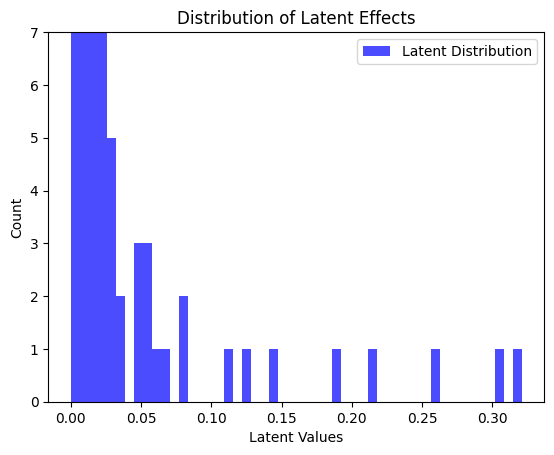

In [47]:
# look at the distribution of the latents
plt.hist(torch.abs(saes[1].igmask.ig_scores).view(-1).cpu().numpy(), bins=50, alpha=0.7, color='blue', label='Latent Distribution')
plt.xlabel('Latent Values')
plt.ylabel('Count')
plt.title('Distribution of Latent Effects')
plt.ylim(0, 7)
plt.legend()
# plot the histogram
plt.show()

In [48]:
saes[0].igmask.get_threshold_info(0.0)

{'total_latents': tensor(12087., device='cuda:0'),
 'avg_latents_per_tok': tensor(185.9538, device='cuda:0'),
 'latents_per_tok': tensor([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.,    0.,    0.,    0., 1161.,  129.,   86.,   77.,  157.,   75.,
           72., 1223.,  117.,  103.,   92.,  171.,   73.,   77., 1299.,  121.,
          150.,   93.,  193.,   83.,   76., 1414.,  133.,  112.,  106.,  203.,
           89.,   76., 1381.,  138.,   76.,  102.,  204.,   55.,   65.,  203.,
          140.,   74., 1695.,  107.,   86.], device='cuda:0')}

In [49]:
def pp(x):
    keys = list(x.keys())
    values = list(x.values())
    for i in range(len(keys)):
        print(f"{keys[i]}: {values[i]}")

In [50]:
ig_masks = produce_ig_binary_masks(threshold=0.01)

In [51]:
threshold = 0.01
sum = 0
for sae in saes:
    print("layer:", sae.cfg.hook_layer)
    latents_in_sae = sae.igmask.get_threshold_info(threshold)['total_latents'].item()
    sum += latents_in_sae
    print(latents_in_sae)

print("total", sum)

print("="*40)
with torch.no_grad():
    ig_logitfn = build_sae_logitfn(ig_mask_threshold=threshold, mean_mask=True)
    metrics = sanity_check_model_performance(ig_logitfn)
    top1_correct_avg = (metrics['top1_correct'] + metrics['top1_error'])/2
    ce_avg = (metrics['ce_loss_correct'] + metrics['ce_loss_error'])/2
    pp(metrics)
    print("avg top1 correct", top1_correct_avg)
    print("avg CE loss", ce_avg)

layer: 7
17.0
layer: 14
79.0
layer: 21
246.0
layer: 40
167.0
total 509.0
prob_age_given_correct: 0.8974571228027344
prob_traceback_given_correct(bad): 0.029454493895173073
logit_diff_correct(-=bad): 5.1295695304870605
top1_correct: 1.0
ce_loss_correct: 0.10869450867176056
prob_traceback_given_error: 0.2267649620771408
prob_age_given_error(bad): 0.21619318425655365
logit_diff_error(-=bad): 2.1616568565368652
top1_error: 0.699999988079071
ce_loss_error: 1.4841965436935425
avg top1 correct 0.8499999940395355
avg CE loss 0.7964455261826515


In [52]:
# Comparison:

def get_faithfulness(logitfn):
    standard_results = sanity_check_model_performance(baseline_model_logit_fn)
    baseline_logit_diff = (standard_results['logit_diff_correct(-=bad)'] + standard_results['logit_diff_error(-=bad)'])/2

    logitfn_results = sanity_check_model_performance(logitfn)
    test_logit_diff = (logitfn_results['logit_diff_correct(-=bad)'] + logitfn_results['logit_diff_error(-=bad)'])/2

    faithfulness_ratio = test_logit_diff/baseline_logit_diff

    return faithfulness_ratio




def get_faithfulness_frontier(mask_producer_fn, start_threshold, end_threshold, steps = 10, modify_fn = lambda x: x):
    thresholds = []
    delta = (end_threshold - start_threshold) / steps

    # apply a linear function such that the linear_map(modify_fn(start_threshold)) = start_threshold
    # and linear_map(modify_fn(end_threshold)) = end_threshold

    def linear_map(x):
        mod_start = modify_fn(start_threshold)
        mod_end = modify_fn(end_threshold)
        return (x - mod_start) / (mod_end - mod_start) * (end_threshold - start_threshold) + start_threshold
    
    mf = lambda x: linear_map(modify_fn(x))
    


    for i in range(steps):
        thresholds.append(
            mf(start_threshold + i*delta)
            )
    
    faithfulness_scores = []
    for threshold in tqdm(thresholds):
        mask = mask_producer_fn(threshold=threshold)
        num_latents = mask.get_num_latents()
        faithfulness_ratio = get_faithfulness(
            build_sae_logitfn(circuit_mask=mask, mean_mask=True)
        )
        faithfulness_scores.append([num_latents, faithfulness_ratio])

    return faithfulness_scores        

ig_faithfulness_frontier = get_faithfulness_frontier(produce_ig_binary_masks, 0.01, 0.3, steps=10, modify_fn=lambda x: x**4)


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


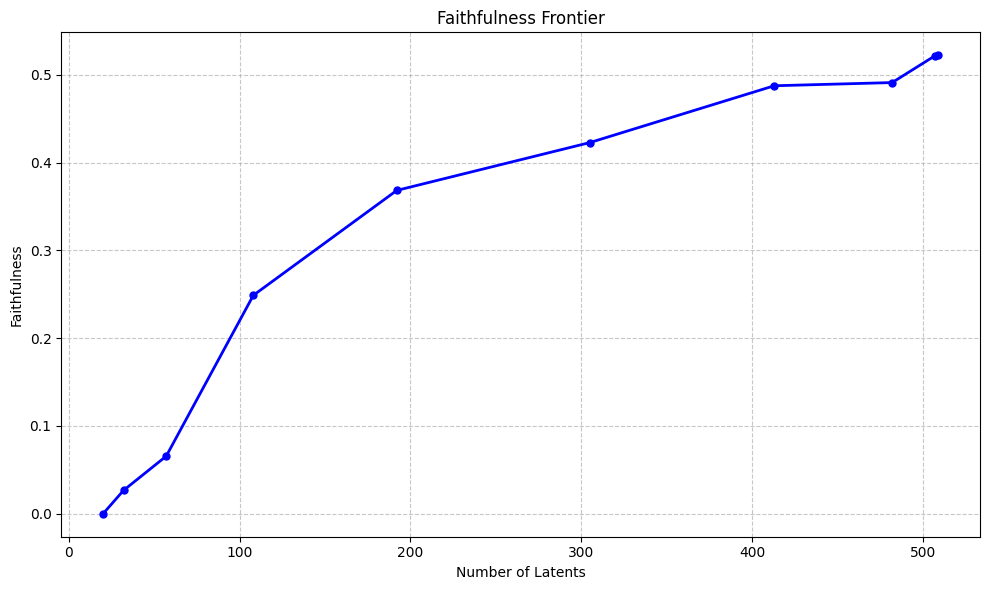

In [53]:

def plot_faithfulness_frontier(faithfulness_frontier):
    # Assuming faithfulness_frontier is your list of tuples
    # Example: faithfulness_frontier = [(10, 0.8), (20, 0.85), (30, 0.89), ...]

    # Unzip the tuples into separate lists for x and y coordinates
    num_latents, faithfulness = zip(*faithfulness_frontier)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(num_latents, faithfulness, 'b.-', linewidth=2, markersize=10)

    # Add labels and title
    plt.xlabel('Number of Latents')
    plt.ylabel('Faithfulness')
    plt.title('Faithfulness Frontier')

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Optionally, you can customize the axis ranges if needed
    # plt.xlim([min(num_latents), max(num_latents)])
    # plt.ylim([min(faithfulness), max(faithfulness)])

    # Display the plot
    plt.tight_layout()
    plt.show()
plot_faithfulness_frontier(ig_faithfulness_frontier)

In [93]:
def plot_multiple_faithfulness_frontiers(frontiers_dict, figsize=(12, 7), styles=None):
    """
    Plot multiple faithfulness frontiers on the same graph.
    
    Parameters:
    -----------
    frontiers_dict : dict
        Dictionary where keys are frontier names and values are lists of tuples (num_latents, faithfulness)
        Example: {
            'Model A': [(10, 0.8), (20, 0.85), ...],
            'Model B': [(10, 0.75), (20, 0.82), ...]
        }
    figsize : tuple, optional
        Figure size in inches (width, height)
    styles : dict, optional
        Dictionary of plot styles for each frontier
        Example: {
            'Model A': {'color': 'blue', 'linestyle': '-', 'marker': 'o'},
            'Model B': {'color': 'red', 'linestyle': '--', 'marker': 's'}
        }
    """
    # Set default styles if none provided
    if styles is None:
        # Define a set of default colors and markers
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
                 '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
        markers = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', '8']
        
        styles = {}
        for i, name in enumerate(frontiers_dict.keys()):
            color_idx = i % len(colors)
            marker_idx = i % len(markers)
            styles[name] = {
                'color': colors[color_idx],
                'linestyle': '-',
                'marker': markers[marker_idx]
            }
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Plot each frontier
    for name, frontier in frontiers_dict.items():
        # Unzip the tuples
        num_latents, faithfulness = zip(*frontier)
        
        # Get style for this frontier
        style = styles[name]
        
        # Plot with style
        plt.plot(num_latents, faithfulness,
                label=name,
                color=style['color'],
                linestyle=style['linestyle'],
                marker=style['marker'],
                linewidth=2,
                markersize=8)
    
    # Customize the plot
    plt.xlabel('Number of Latents', fontsize=12)
    plt.ylabel('Faithfulness', fontsize=12)
    plt.title('Faithfulness vs Num. Latents', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

# Optimize Binary Mask

In [55]:
batch_size = 16
simple_dataset = simple_dataset[:batch_size*(len(simple_dataset)//batch_size)]
simple_labels = simple_labels[:batch_size*(len(simple_labels)//batch_size)]

simple_dataset = simple_dataset.view(-1, batch_size, 65)
simple_labels = simple_labels.view(-1, batch_size)

In [56]:
def logitfn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True)
        )

def forward_pass(batch, labels, logitfn, ratio_trained=1):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    sparsity_loss = 0
    for sae in saes:
        sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
    sparsity_loss = sparsity_loss / len(saes)
    return loss, sparsity_loss

In [57]:
def mask_logits(logits):
    """
    Mask logits to only allow tokens in vocab_tensor by setting all other logits to -inf.
    Works with any number of leading batch dimensions.
    
    Args:
        logits: Tensor of shape [..., vocab_size] containing the logits
    
    Returns:
        Tensor of same shape as logits with all non-vocab logits set to -inf
    """
    vocab_tensor = simple_labels.view(-1).unique()
    mask = torch.zeros_like(logits)
    mask[..., vocab_tensor] = 1
    return logits.masked_fill(mask == 0, float('-inf'))

In [75]:
answer_token = model.to_single_token("1")
traceback_token = model.to_single_token("Traceback")

In [77]:
def do_training_run(sparsity_multiplier, loss_function='ce', per_token_mask=False, use_mask=False, mean_mask=False, distinct_sparsity_multiplier=0):

    def logitfn(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask)
            )
        if loss_function == 'ce_vocab':
            return mask_logits(logits)
        return logits

    def forward_pass(batch, labels, logitfn, ratio_trained=1):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        if loss_function == 'ce' or loss_function == 'ce_vocab':
            loss = F.cross_entropy(last_token_logits, labels)
            
        elif loss_function == 'logit_diff':
            # from the last token logits, get the logit for the "1" token and the "Traceback" token
            correct_logits = last_token_logits[torch.arange(last_token_logits.shape[0]), labels]
            incorrect_labels = torch.where(labels == answer_token, traceback_token, answer_token)
            incorrect_logits = last_token_logits[torch.arange(last_token_logits.shape[0]), incorrect_labels]
            loss = (incorrect_logits - correct_logits).mean() # it should very negative if the model is right.
        else:
            raise ValueError(f"Loss function {loss_function} not recognized")
        sparsity_loss = 0
        if per_token_mask:
            distinct_sparsity_loss = 0
        for sae in saes:
            sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
            if per_token_mask:
                distinct_sparsity_loss = distinct_sparsity_loss + sae.mask.distinct_sparsity_loss
        
        sparsity_loss = sparsity_loss / len(saes)
        distinct_sparsity_loss = distinct_sparsity_loss / len(saes)

        return loss, sparsity_loss, distinct_sparsity_loss

    print("doing a run with sparsity multiplier", sparsity_multiplier)
    all_optimized_params = []
    config = {
        "batch_size": 16,
        "learning_rate": 0.05,
        "total_steps": simple_dataset.shape[0]*0.01,
        "sparsity_multiplier": sparsity_multiplier
    }

    for sae in saes:
        if per_token_mask:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0, seq_len=65, distinct_l1=1.0)
        else:
            sae.mask = SparseMask(sae.cfg.d_sae, 1.0)
        all_optimized_params.extend(list(sae.mask.parameters()))
        sae.mask.max_temp = torch.tensor(200.0)
    
    wandb.init(project="sae circuits", config=config)
    optimizer = optim.Adam(all_optimized_params, lr=config["learning_rate"])
    total_steps = config["total_steps"]

    with tqdm(total=total_steps, desc="Training Progress") as pbar:
        for i, (x, y) in enumerate(zip(simple_dataset, simple_labels)):
            with KeyboardInterruptBlocker():
                optimizer.zero_grad()
                
                # Calculate ratio trained
                ratio_trained = i / total_steps
                
                # Update mask ratio for each SAE
                for sae in saes:
                    sae.mask.ratio_trained = ratio_trained
                
                # Forward pass with updated ratio_trained
                loss, sparsity_loss, distinct_sparsity_loss = forward_pass(x, y, logitfn, ratio_trained=ratio_trained)
                if per_token_mask:
                    sparsity_loss = sparsity_loss / 65


                avg_nonzero_elements = sparsity_loss
                avg_distinct_nonzero_elements = distinct_sparsity_loss
                    
                sparsity_loss = sparsity_loss * config["sparsity_multiplier"] + distinct_sparsity_loss * distinct_sparsity_multiplier
                total_loss = loss + sparsity_loss
                infodict  = {"Step": i, "Progress": ratio_trained, "Avg Nonzero Elements": avg_nonzero_elements.item(), "avg distinct lat/sae":avg_distinct_nonzero_elements.item(), "Task Loss": loss.item(), "Sparsity Loss": sparsity_loss.item(), "temperature": saes[0].mask.temperature}
                wandb.log(infodict)
                
                # Backward pass and optimizer step
                total_loss.backward()
                optimizer.step()
                
                # Update tqdm bar with relevant metrics
                pbar.set_postfix(infodict)
                
                # Update the tqdm progress bar
                pbar.update(1)
                if i >= total_steps*1.3:
                    break
    wandb.finish()

    optimizer.zero_grad()

    for sae in saes:
        for param in sae.parameters():
            param.grad = None
        for param in sae.mask.parameters():
            param.grad = None
    
    for param in model.parameters():
        param.grad = None

    torch.cuda.empty_cache()

    mask_dict = {}

    total_density = 0
    for sae in saes:
        mask_dict[sae.cfg.hook_name] = torch.where(torch.sigmoid(sae.mask.mask*10000))[0].tolist()   # rob thinks .view(-1) needed here
        total_density += torch.sigmoid(sae.mask.mask*10000).sum().item()
    mask_dict["total_density"] = total_density
    mask_dict['avg_density'] = total_density / len(saes)

    if per_token_mask:
        print("total # latents in circuit: ", total_density)
    print("avg density", mask_dict['avg_density'])

    ### EVAL ###
    def masked_logit_fn(tokens):
        logits =  model.run_with_hooks(
            tokens, 
            return_type="logits", 
            fwd_hooks=build_hooks_list(tokens, use_mask=use_mask, mean_mask=mean_mask, binarize_mask=True)
            )
        if loss_function == 'ce_vocab':
            return mask_logits(logits)
        return logits

    def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
        for sae in saes:
            sae.mask.ratio_trained = ratio_trained
        tokens = batch
        logits = logitfn(tokens)
        last_token_logits = logits[:, -1, :]
        loss = F.cross_entropy(last_token_logits, labels)

        # sparsity_loss = 0
        # for sae in saes:
        #     sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
        
        # sparsity_loss = sparsity_loss / len(saes)

        return loss

    with torch.no_grad():
        loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], masked_logit_fn)
        print("CE loss:", loss)

    mask_dict['ce_loss'] = loss.item()


    # json.dump(mask_dict, open(f"{str(sparsity_multiplier)}_run.json", "w"))
    
    

In [59]:
def masked_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True, binarize_mask=True)
        )

def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)

    # sparsity_loss = 0
    # for sae in saes:
    #     sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
    # sparsity_loss = sparsity_loss / len(saes)

    return loss

with torch.no_grad():
    loss = eval_ce_loss(simple_dataset[21], simple_labels[21], masked_logit_fn)
    
    print("CE loss:", loss)



CE loss: tensor(0.9181, device='cuda:0')


In [78]:
# do_training_run(14, loss_function='logit_diff', per_token_mask=True, use_mask=True, mean_mask=True)
# do_training_run(0.1, loss_function="ce", per_token_mask=True, use_mask=True, mean_mask=True, distinct_sparsity_multiplier=0.02)
# do_training_run(0.025, per_token_mask=False, use_mask=True, mean_mask=True)
do_training_run(3.0, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True)


doing a run with sparsity multiplier 3.0


Training Progress:   0%|          | 0/125.0 [00:00<?, ?it/s]

Training Progress: 164it [03:51,  1.41s/it, Step=163, Progress=1.3, Avg Nonzero Elements=0.677, avg distinct lat/sae=40, Task Loss=-5.28, Sparsity Loss=2.03, temperature=tensor(1001.2515, device='cuda:0')]                                  


Avg Nonzero Elements,█████▅▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
Sparsity Loss,█████▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
Task Loss,██▆▆▆▄▅▅▄▄▄▃▂▄▅▄▂▁▄▄▄▂▃▂▃▄▃▃▂▃▂▂▂▅▃▄▂▃▃▁
avg distinct lat/sae,███▇▇▅▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▆▆█
Avg Nonzero Elements,0.67692
Progress,1.304
Sparsity Loss,2.03077
Step,163


total # latents in circuit:  176.0
avg density 44.0
CE loss: tensor(0.6624, device='cuda:0')


In [80]:
learned_masks = produce_learned_binary_masks()
print(
sanity_check_model_performance(
    build_sae_logitfn(circuit_mask=learned_masks, mean_mask=True)
)
)

print(
get_faithfulness(
    build_sae_logitfn(circuit_mask=learned_masks, mean_mask=True)
)
)

{'prob_age_given_correct': 0.924264132976532, 'prob_traceback_given_correct(bad)': 0.022306686267256737, 'logit_diff_correct(-=bad)': 8.00454330444336, 'top1_correct': 1.0, 'ce_loss_correct': 0.0787598267197609, 'prob_traceback_given_error': 0.3965848386287689, 'prob_age_given_error(bad)': 0.20049957931041718, 'logit_diff_error(-=bad)': 3.151041030883789, 'top1_error': 1.0, 'ce_loss_error': 0.9248655438423157}
0.7988578377303777


In [282]:
def logitfn(tokens, vocab_mask=False):
    logits =  model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True, binarize_mask=True)
        )
    if vocab_mask:
        return mask_logits(logits)
    return logits


In [289]:
with torch.no_grad():
    pp(sanity_check_model_performance(logitfn))

prob_age_given_correct: 0.874530017375946
prob_traceback_given_correct(bad): 0.03809851035475731
logit_diff_correct(-=bad): 4.940079689025879
top1_correct: 1.0
ce_loss_correct: 0.13407503068447113
prob_traceback_given_error: 0.6129750609397888
prob_age_given_error(bad): 0.131747767329216
logit_diff_error(-=bad): 2.947051525115967
top1_error: 1.0
ce_loss_error: 0.48943108320236206


In [161]:
def logitfn(tokens, vocab_mask=False):
    logits =  model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, mean_mask=True, binarize_mask=True)
        )
    if vocab_mask:
        return mask_logits(logits)
    return logits

# def forward_pass(batch, labels, logitfn, ratio_trained=1):
#     for sae in saes:
#         sae.mask.ratio_trained = ratio_trained
#     tokens = batch
#     logits = logitfn(tokens)
#     last_token_logits = logits[:, -1, :]
#     loss = F.cross_entropy(last_token_logits, labels)
#     sparsity_loss = 0
#     for sae in saes:
#         sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
#     sparsity_loss = sparsity_loss / len(saes)

    return loss, sparsity_loss
with torch.no_grad():
    idx = 0
    print("original example")
    print(f"{model.to_string(simple_dataset[-1][idx])}")
    print("original label")
    print(model.to_string(simple_labels[-1][idx:idx+1]))
    logits = logitfn(simple_dataset[-1][idx:idx+1][-1])[-1][-1]
    print(logits.shape)
    probs = F.softmax(logits, dim=-1)
    print(probs.shape)
    # get the top 3 tokens and their probabilities
    topk = torch.topk(probs, k=3)
    print(model.to_str_tokens(topk.indices))
    print(topk.values)
    # get the cross entropy loss
    loss = F.cross_entropy(logits.unsqueeze(0), simple_labels[-1][idx:idx+1])
    print(f"ce loss {loss}")

with torch.no_grad():
    correct = 0
    num_items = 16
    for i in range(num_items):
        example = simple_dataset[-2][i]
        label = simple_labels[-2][i]
        logits = logitfn(example)[-1][-1]
        top_logit = torch.argmax(logits)
        if top_logit == label:
            print("correct", model.to_string(label))
            correct += 1
        else:
            print("error", model.to_string(label))
        
    print(f"correct: {correct} out of {num_items}")

original example
<bos>Type "help", "copyright", "credits" or "license" for more information.
>>> age = {'Bob': 14, 'Lucas': 12, 'Rob': 15, 'Jackson': 11, 'Tom': 11}
>>> age["Jackson"]

original label
1
torch.Size([256000])
torch.Size([256000])
['1', '>>>', '2']
tensor([0.8805, 0.0355, 0.0118], device='cuda:0')
ce loss 0.12732182443141937
correct 1
correct Traceback
correct Traceback
correct Traceback
correct 1
correct 1
correct 1
correct Traceback
correct 1
correct 1
correct Traceback
correct 1
correct Traceback
correct Traceback
correct Traceback
correct 1
correct: 16 out of 16


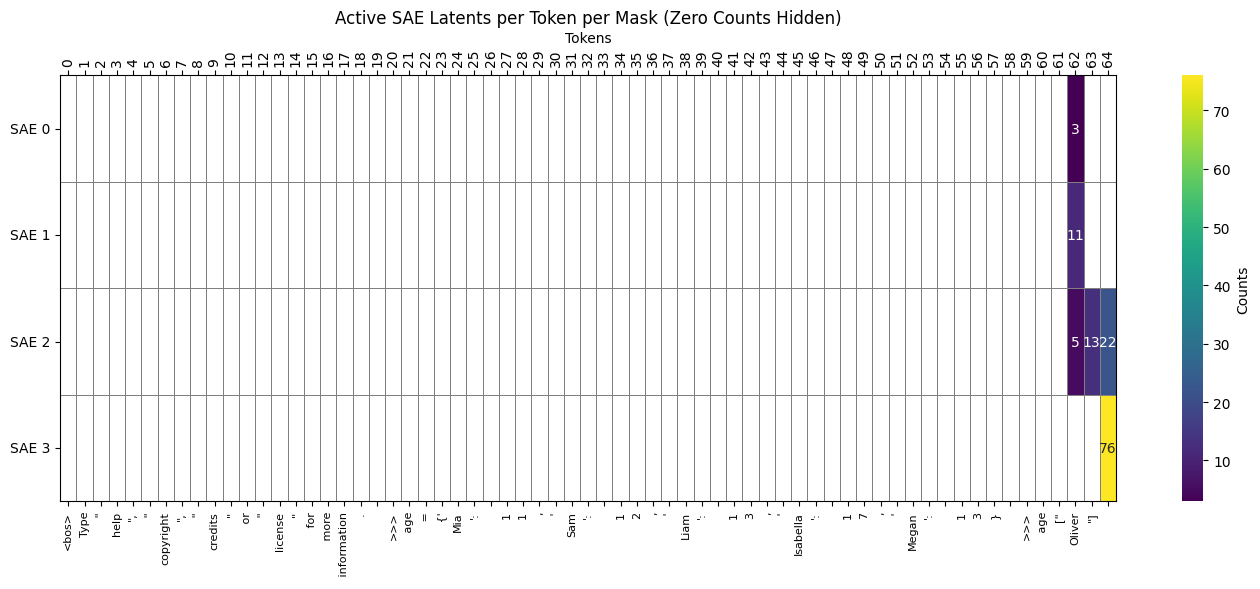

layer 0 latents: 3 🖕
layer 1 latents: 11 🖕
layer 2 latents: 40 🖕
layer 3 latents: 76 🖕
total # latents: 130 🖕


In [288]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# Assuming 'saes', 'model', and 'simple_dataset' are defined
tokens = model.to_str_tokens(simple_dataset[2][0])
num_masks = 4 # Number of masks you have
counts_per_mask = []
for mask_index in range(num_masks):
    testmask = saes[mask_index].mask.mask.data.clone()
    binarized = (testmask > 0.0).float()
    counts = []
    for i in range(len(tokens)):
        counts.append(torch.count_nonzero(binarized[i]).item())
    counts_per_mask.append(counts)

# Convert counts to a NumPy array
data = np.array(counts_per_mask) # Shape: (num_masks, num_tokens)

# Create a mask for zero values
zero_mask = data == 0

# Define a colormap
cmap = sns.color_palette("viridis", as_cmap=True)

# Plot the heatmap with the mask
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    data,
    annot=True,
    fmt='d',
    cmap=cmap,
    mask=zero_mask,
    cbar_kws={'label': 'Counts'},
    linewidths=0.5,
    linecolor='gray'
)

# Set x-axis labels to tokens
ax.set_xticks(np.arange(len(tokens)) + 0.5)
ax.set_xticklabels(tokens, rotation=90, fontsize=8)

# Add numeric indices above the chart
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(len(tokens)) + 0.5)
ax2.set_xticklabels(np.arange(len(tokens)), rotation=90)  # Rotate indices 90 degrees
ax2.set_xlabel('Token Indices')

# Set y-axis labels to masks
ax.set_yticks(np.arange(num_masks) + 0.5)
ax.set_yticklabels([f'SAE {i}' for i in range(num_masks)], rotation=0)

plt.xlabel('Tokens')
plt.ylabel('SAE Number Active Latents')
plt.title('Active SAE Latents per Token per Mask (Zero Counts Hidden)')
plt.tight_layout()
plt.show()

# print the total # latents in the circuit
total_latents = 0
for i, sae in enumerate(saes):
    print(f"layer {i} latents: {torch.sum(sae.mask.mask > 0)} ")
    total_latents += torch.sum(sae.mask.mask > 0)
print(f"total # latents: {total_latents} ")


In [120]:
torch.nonzero(saes[2].mask.mask[64]>0)

tensor([[   52],
        [  639],
        [  712],
        [  718],
        [ 1197],
        [ 1408],
        [ 4708],
        [ 6650],
        [ 7192],
        [ 8082],
        [ 8127],
        [ 9551],
        [10003],
        [11135],
        [12314],
        [12598]], device='cuda:0')

In [119]:
print(model.to_string(simple_dataset[0][2]))

<bos>Type "help", "copyright", "credits" or "license" for more information.
>>> age = {'Isabella': 49, 'Emma': 78, 'Tom': 27, 'Ethan': 48, 'Ava': 62}
>>> age["Ava"]



## HPRAM sweep

In [81]:
def produce_learned_binary_mask(threshold):
    do_training_run(threshold, loss_function="logit_diff", per_token_mask=True, use_mask=True, mean_mask=True)
    learned_masks = produce_learned_binary_masks()
    return learned_masks

In [90]:
learned_faithfulness_frontier = get_faithfulness_frontier(produce_learned_binary_mask, 1.4, 30, steps=10, modify_fn=lambda x: x**2)

  0%|          | 0/10 [00:00<?, ?it/s]

doing a run with sparsity multiplier 1.4


Training Progress: 164it [03:51,  1.41s/it, Step=163, Progress=1.3, Avg Nonzero Elements=1.1, avg distinct lat/sae=65.2, Task Loss=-6.15, Sparsity Loss=1.53, temperature=tensor(1001.2515, device='cuda:0')]


Avg Nonzero Elements,███▇▇▄▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
Sparsity Loss,███▇▇▆▆▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇███
Task Loss,██▆▇▅▃▃▂▃▄▄▃▅▁▃▄▁▃▂▃▂▂▄▃▂▂▁▂▂▃▁▂▄▃▄▄▁▃▄▄
avg distinct lat/sae,█████▇▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▅▇█
Avg Nonzero Elements,1.09615
Progress,1.304
Sparsity Loss,1.53462
Step,163


total # latents in circuit:  285.0
avg density 71.25
CE loss: tensor(0.5347, device='cuda:0')


 10%|█         | 1/10 [03:56<35:25, 236.14s/it]

doing a run with sparsity multiplier 1.915528662420382


Training Progress: 164it [03:52,  1.42s/it, Step=163, Progress=1.3, Avg Nonzero Elements=0.904, avg distinct lat/sae=53.2, Task Loss=-5.82, Sparsity Loss=1.73, temperature=tensor(1001.2515, device='cuda:0')]


Avg Nonzero Elements,█▇▇▆▆▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇███
Sparsity Loss,███▇▆▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
Task Loss,██▇▆▆▅▄▅▆▆▃▅▃▄▄▅▄▄▄▅▁▅▄▄▅▄▅▅▃▅▆▅▄▃▂▅▃▅▄▂
avg distinct lat/sae,██▇▇▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▅▆▇▇▇█
Avg Nonzero Elements,0.90385
Progress,1.304
Sparsity Loss,1.73134
Step,163


total # latents in circuit:  235.0
avg density 58.75
CE loss: tensor(0.6037, device='cuda:0')


 20%|██        | 2/10 [07:53<31:35, 236.95s/it]

doing a run with sparsity multiplier 2.9520509554140135


Training Progress: 164it [03:52,  1.42s/it, Step=163, Progress=1.3, Avg Nonzero Elements=0.685, avg distinct lat/sae=40.5, Task Loss=-5.3, Sparsity Loss=2.02, temperature=tensor(1001.2515, device='cuda:0')]


Avg Nonzero Elements,██▆▅▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
Sparsity Loss,████▇▇▆▆▄▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Task Loss,█▇▇▆▇▅▆▅▅▄▃▄▄▄▃▄▅▄▅▄▅▄▅▄▄▄▁▄▂▃▃▅▃▄▃▃▂▄▅▄
avg distinct lat/sae,██▇▇▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▇█
Avg Nonzero Elements,0.68462
Progress,1.304
Sparsity Loss,2.02102
Step,163


total # latents in circuit:  178.0
avg density 44.5
CE loss: tensor(0.6568, device='cuda:0')


 30%|███       | 3/10 [11:51<27:40, 237.19s/it]

doing a run with sparsity multiplier 4.509566878980894


Training Progress: 164it [03:52,  1.42s/it, Step=163, Progress=1.3, Avg Nonzero Elements=0.477, avg distinct lat/sae=29.2, Task Loss=-4.38, Sparsity Loss=2.15, temperature=tensor(1001.2515, device='cuda:0')]


Avg Nonzero Elements,███▇▇▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
Sparsity Loss,██▇▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
Task Loss,█▆▆▅▇▆▅▅▄▅▆▄▃▃▃▃▃▅▁▃▃▄▃▄▅▃▃▃▄▃▃▆▄▄▂▂▄▄▁▄
avg distinct lat/sae,█▇▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▄▅▇█
Avg Nonzero Elements,0.47692
Progress,1.304
Sparsity Loss,2.15072
Step,163


total # latents in circuit:  124.0
avg density 31.0
CE loss: tensor(0.7176, device='cuda:0')


 40%|████      | 4/10 [15:48<23:44, 237.39s/it]

doing a run with sparsity multiplier 6.588076433121021


Training Progress: 164it [03:52,  1.42s/it, Step=163, Progress=1.3, Avg Nonzero Elements=0.323, avg distinct lat/sae=19.5, Task Loss=-3.56, Sparsity Loss=2.13, temperature=tensor(1001.2515, device='cuda:0')]


Avg Nonzero Elements,███▇▇▆▆▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇███
Sparsity Loss,███▇▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
Task Loss,▇█▇▇▅▇▇▃▄▄▃▄▆▅▆▆▃▅▆▃▃▅▃▄▃▃▄▃▅▂▆▁▄▅▅▅▄▂▂▅
avg distinct lat/sae,███▇▆▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▅▅▆▇█
Avg Nonzero Elements,0.32308
Progress,1.304
Sparsity Loss,2.12846
Step,163


total # latents in circuit:  84.0
avg density 21.0
CE loss: tensor(0.8149, device='cuda:0')


 50%|█████     | 5/10 [19:46<19:47, 237.41s/it]

doing a run with sparsity multiplier 9.187579617834396


Training Progress: 164it [03:52,  1.42s/it, Step=163, Progress=1.3, Avg Nonzero Elements=0.242, avg distinct lat/sae=15, Task Loss=-2.97, Sparsity Loss=2.23, temperature=tensor(1001.2515, device='cuda:0')]


Avg Nonzero Elements,███▆▆▅▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
Sparsity Loss,█████▇▇▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
Task Loss,▇█▅▁▅▆▆▇▆▆▇▄▄▂▃▄▄▂▄▆▄▅▄▆▄▄▃▄▃▄▄▃▃▄▄▅▅▄▆▆
avg distinct lat/sae,███▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▅▅▆▆▇▇█
Avg Nonzero Elements,0.24231
Progress,1.304
Sparsity Loss,2.22622
Step,163


total # latents in circuit:  63.0
avg density 15.75
CE loss: tensor(0.8818, device='cuda:0')


 60%|██████    | 6/10 [23:44<15:50, 237.60s/it]

doing a run with sparsity multiplier 12.308076433121023


Training Progress: 164it [03:52,  1.42s/it, Step=163, Progress=1.3, Avg Nonzero Elements=0.177, avg distinct lat/sae=11, Task Loss=-2.02, Sparsity Loss=2.18, temperature=tensor(1001.2515, device='cuda:0')]


Avg Nonzero Elements,██▇▆▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
Sparsity Loss,███▇▇▅▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇███
Task Loss,▁▅▂▆▁▄▃▃▁▆▇▇▃▆▅▅▇▇█▂▆▅▂▅▆▄▆▆▄▄▆▄▆▁▅▅▁▆▅▆
avg distinct lat/sae,████▇▆▅▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▄▄▅▆█
Avg Nonzero Elements,0.17692
Progress,1.304
Sparsity Loss,2.17758
Step,163


total # latents in circuit:  46.0
avg density 11.5
CE loss: tensor(1.0234, device='cuda:0')


 70%|███████   | 7/10 [27:42<11:52, 237.66s/it]

doing a run with sparsity multiplier 15.949566878980896


Training Progress: 164it [03:52,  1.42s/it, Step=163, Progress=1.3, Avg Nonzero Elements=0.138, avg distinct lat/sae=8.5, Task Loss=-1.57, Sparsity Loss=2.21, temperature=tensor(1001.2515, device='cuda:0')]


Avg Nonzero Elements,█████▇▅▄▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
Sparsity Loss,██▇▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
Task Loss,▃▅▁▁▂▆▇▆▇██▇█▇▇█▄▅▄▆▇▃▅▃▅▄▆▄▇▅▆▅▄▄▆▁▅▅▆▅
avg distinct lat/sae,█▇▆▆▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▅▆▆█
Avg Nonzero Elements,0.13846
Progress,1.304
Sparsity Loss,2.2084
Step,163


total # latents in circuit:  36.0
avg density 9.0
CE loss: tensor(1.1810, device='cuda:0')


 80%|████████  | 8/10 [31:39<07:55, 237.59s/it]

doing a run with sparsity multiplier 20.112050955414013


Training Progress: 164it [03:52,  1.42s/it, Step=163, Progress=1.3, Avg Nonzero Elements=0.0923, avg distinct lat/sae=5.75, Task Loss=-0.398, Sparsity Loss=1.86, temperature=tensor(1001.2515, device='cuda:0')]


Avg Nonzero Elements,█████▇▆▆▆▅▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
Sparsity Loss,████▇▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇█
Task Loss,▁▂▃▄▂▂▃▆▆▅▇▇▆▇▆▇▅▆▆▆▇▆▇▇█▇▆▆▇▆▆▅▆▆█▇▇▆▅▇
avg distinct lat/sae,████▇▆▆▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▅▅▅█
Avg Nonzero Elements,0.09231
Progress,1.304
Sparsity Loss,1.8565
Step,163


total # latents in circuit:  24.0
avg density 6.0
CE loss: tensor(1.5766, device='cuda:0')


 90%|█████████ | 9/10 [35:36<03:57, 237.55s/it]

doing a run with sparsity multiplier 24.795528662420384


Training Progress: 164it [03:50,  1.41s/it, Step=163, Progress=1.3, Avg Nonzero Elements=0.0269, avg distinct lat/sae=1.75, Task Loss=0.288, Sparsity Loss=0.668, temperature=tensor(1001.2515, device='cuda:0')]


Avg Nonzero Elements,██▅▄▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Progress,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
Sparsity Loss,████▇▇▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Step,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇███
Task Loss,▁▁▄▂▂▃▃▅▆▆▆▆▇▇▆▆██▅▇▇▆▆▇▆▇█▅▆▇▆▅▇▆█▇▇▇▇█
avg distinct lat/sae,██▇▇▇▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temperature,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▅▅▅▆▆▇█
Avg Nonzero Elements,0.02692
Progress,1.304
Sparsity Loss,0.66757
Step,163


total # latents in circuit:  7.0
avg density 1.75
CE loss: tensor(2.1259, device='cuda:0')


100%|██████████| 10/10 [39:32<00:00, 237.24s/it]


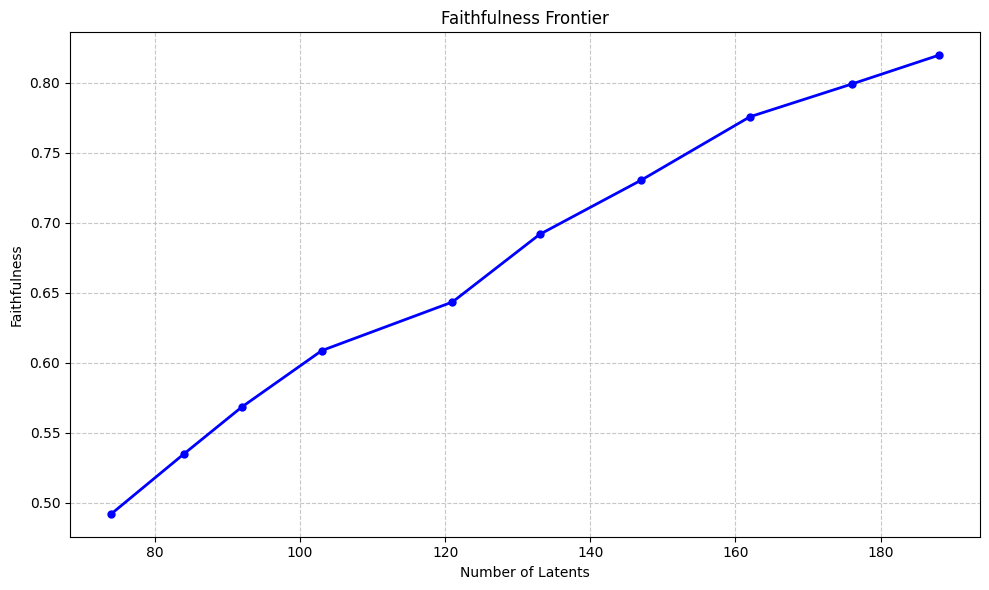

In [84]:
plot_faithfulness_frontier(learned_faithfulness_frontier)

In [103]:
# save faithfulness frontier to disk
import json
json.dump(faithfulness_frontier, open("learned_faithfulness_frontier.json", "w"))

## Eval

In [ ]:
def masked_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens, use_mask=True, binarize_mask=True, mean_mask=True)
        )

In [ ]:
def baseline_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=[]
        )

In [ ]:
def baseline_sae_logit_fn(tokens):
    return model.run_with_hooks(
        tokens, 
        return_type="logits", 
        fwd_hooks=build_hooks_list(tokens)
        )

In [ ]:
# serialize the masks
mask_dict = {}
for sae in saes:
    mask_dict[sae.cfg.hook_name] = torch.where(torch.sigmoid(sae.mask.mask*10000))[0].tolist()

json.dump(mask_dict, open("mask_dict.json", "w"))
len(mask_dict["blocks.7.hook_resid_post"])

5

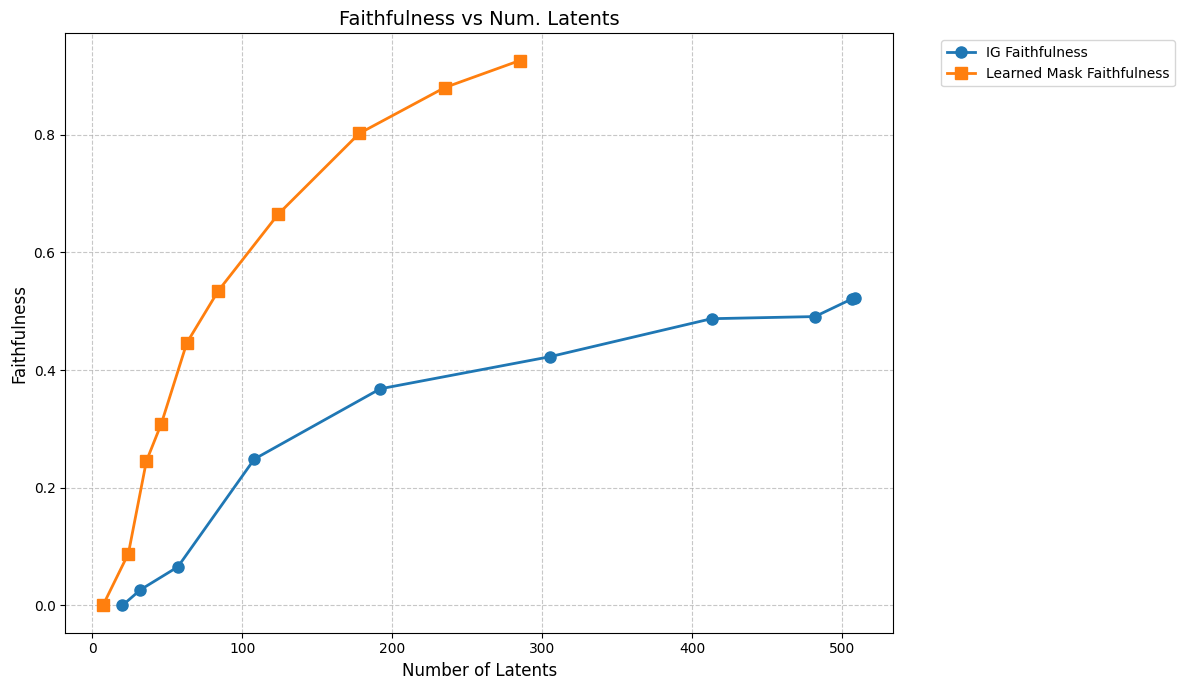

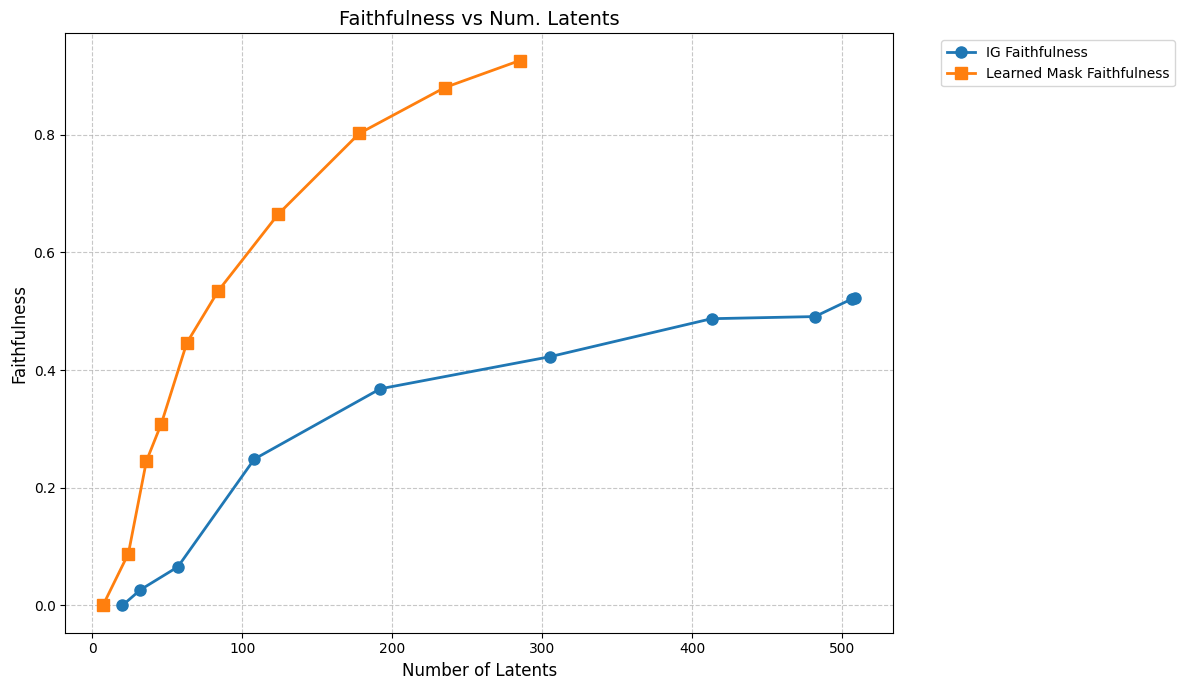

In [94]:
plot_multiple_faithfulness_frontiers({
    'IG Faithfulness': ig_faithfulness_frontier,
    'Learned Mask Faithfulness': learned_faithfulness_frontier
}, figsize=(12, 7))

In [ ]:
for sae in saes:
    mask = sae.mask.mask
    print(f"Nonzero elements in mask for {sae.cfg.hook_name}: {torch.count_nonzero(torch.sigmoid(mask*1000))}")

Nonzero elements in mask for blocks.7.hook_resid_post: 5
Nonzero elements in mask for blocks.14.hook_resid_post: 13
Nonzero elements in mask for blocks.21.hook_resid_post: 20
Nonzero elements in mask for blocks.40.hook_resid_post: 45


In [ ]:
def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    sparsity_loss = 0
    for sae in saes:
        sparsity_loss = sparsity_loss + sae.mask.sparsity_loss
    
    sparsity_loss = sparsity_loss / len(saes)

    return loss

with torch.no_grad():
    loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], baseline_logit_fn)
    print("baseline loss:", loss)

with torch.no_grad():
    loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], baseline_sae_logit_fn)
    print("sae loss: ", loss)

with torch.no_grad():
    loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], masked_logit_fn)
    print("ablated loss: ", loss)

baseline loss: tensor(0.0276, device='cuda:0')
sae loss:  tensor(0.8250, device='cuda:0')
ablated loss:  tensor(0.4248, device='cuda:0')


In [ ]:
def eval_ce_loss(batch, labels, logitfn, ratio_trained=10):
    # Assuming 'saes' is defined elsewhere in your code
    for sae in saes:
        sae.mask.ratio_trained = ratio_trained
    tokens = batch
    logits = logitfn(tokens)
    last_token_logits = logits[:, -1, :]
    loss = F.cross_entropy(last_token_logits, labels)
    sparsity_loss = 0
    for sae in saes:
        sparsity_loss += sae.mask.sparsity_loss
    
    sparsity_loss = sparsity_loss / len(saes)
    total_loss = loss + sparsity_loss

    return loss.item()  # Return the loss as a scalar value



In [ ]:
results_list = []

# Method: VANILLA GEMMA 9B
method_name = "VANILLA GEMMA 9B"
with torch.no_grad():
    results = sanity_check_model_performance(baseline_logit_fn)
    # Compute cross-entropy loss
    ce_loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], baseline_logit_fn)
    results['ce_loss'] = ce_loss
    results['method'] = method_name
    results_list.append(results)

# Method: GEMMA 9B WITH SAE (no masks)
method_name = "GEMMA 9B WITH SAE (no masks)"
with torch.no_grad():
    results = sanity_check_model_performance(baseline_sae_logit_fn)
    # Compute cross-entropy loss
    ce_loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], baseline_sae_logit_fn)
    results['ce_loss'] = ce_loss
    results['method'] = method_name
    results_list.append(results)

# Method: GEMMA 9B WITH SAE Masked
method_name = "GEMMA 9B WITH SAE Masked"
with torch.no_grad():
    results = sanity_check_model_performance(masked_logit_fn)
    # Compute cross-entropy loss
    ce_loss = eval_ce_loss(simple_dataset[-1], simple_labels[-1], masked_logit_fn)
    results['ce_loss'] = ce_loss
    results['method'] = method_name
    results_list.append(results)

# Create a DataFrame and display it with descriptive column names
df = pd.DataFrame(results_list)
df = df.set_index('method')  # Set 'method' as the index

# Rename columns for better readability
df = df.rename(columns={
    'prob_correct_in_correct': 'P(Age|Correct Ex)',
    'prob_error_in_correct': 'P(Traceback|Correct Ex)',
    'logit_diff_correct': 'Logit Diff (Correct Ex)',
    'prob_error_in_error': 'P(Traceback|Error Ex)',
    'prob_correct_in_error': 'P(Age|Error Ex)',
    'logit_diff_error': 'Logit Diff (Error Ex)',
    'ce_loss': 'Cross-Entropy Loss'
})

# Display the DataFrame
df


,P(Age|Correct Ex),P(Traceback|Correct Ex),Logit Diff (Correct Ex),P(Traceback|Error Ex),P(Age|Error Ex),Logit Diff (Error Ex),Cross-Entropy Loss
method,,,,,,,
VANILLA GEMMA 9B,0.979983,0.001325,6.898462,0.959781,0.000997,6.925329,0.027596
GEMMA 9B WITH SAE (no masks),0.929262,0.001051,6.914926,0.176590,0.025586,2.025202,0.825018
GEMMA 9B WITH SAE Masked,0.828356,0.015461,4.076188,0.469673,0.076615,1.813243,0.424774
